In [1]:
#!pip install tf-nightly==2.5.0.dev20201111 -qqq --progress-bar off
import tensorflow as tf
print(tf.__version__)
assert tf.__version__== '2.5.0-dev20201111','bad version'

2.5.0-dev20201111


In [2]:
cd /Users/aidasaglinskas/Desktop/BC-MRI-AE/Colab Notebooks

/Users/aidasaglinskas/Desktop/BC-MRI-AE/Colab Notebooks


In [3]:
%matplotlib inline
from datetime import datetime;now = datetime.now;t00 = now()
import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

#from contrastive_vae.celeb_utils import get_celeb_vae
#from contrastive_vae.celeb_utils import get_celeb_cvae

import pandas as pd
from sklearn.metrics import silhouette_score

from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

print(now()-t00)

0:00:00.505740


In [4]:
cd ../

/Users/aidasaglinskas/Desktop/BC-MRI-AE


In [5]:
# get abide dataframe
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=1)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

,index,BIDS_ID,ID,SUB_TYPE,VISIT,DAY_LAG,ABIDE_01,ABIDE_02,ABIDE_03,ABIDE_04,...,ABIDE_64,ABIDE_65,ABIDE_66,ABIDE_67,ABIDE_68,ABIDE_69,ABIDE_70,ABIDE_71,ABIDE_72,ABIDE_73
0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [6]:
TD_subs = ABIDE_data[np.array(df['SUB_TYPE']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['SUB_TYPE']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 64, 64, 64)
(456, 64, 64, 64)


In [7]:
dxArr = np.ones(len(df))
dxArr[np.array(df['SUB_TYPE']=='PATIENT')]=2

In [8]:
batch_size = 32

TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:]
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:]

In [9]:
# get VAE
encoder, decoder, vae = get_MRI_CVAE_3D(input_shape=(64, 64, 64, 1), latent_dim=2, batch_size=32, disentangle=False, gamma=1)
vae.load_weights('../tf_outputs/weights/lol');

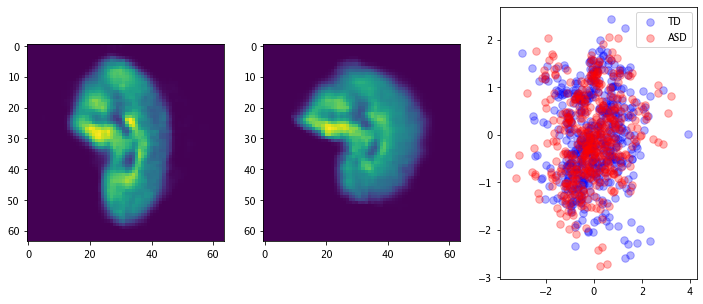

In [10]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(vae.predict(TD_batch)[0,32,:,:,0])
plt.subplot(1,3,2)
plt.imshow(decoder.predict(np.random.randn(3,2))[0,32,:,:,0])
plt.subplot(1,3,3)
arr = encoder.predict(ABIDE_data)[2]
plt.plot(arr[dxArr==1,0],arr[dxArr==1,1],'b.',markersize=15,alpha=.3)
plt.plot(arr[dxArr==2,0],arr[dxArr==2,1],'r.',markersize=15,alpha=.3)
plt.legend(['TD','ASD'])

In [11]:
cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D()
weights_fn = '../tf_outputs/3D_CCVAE_Weights/lol'
#weights_fn = '../../../My Drive/tf_outputs/3D_CCVAE_Weights/lol'
cvae.load_weights(weights_fn)

In [12]:
def project_data(data,dxArr,lbls):
    plt.figure(figsize=(12,4));
    plt.subplot(1,3,1);
    z_mean, z_log_var, z = z_encoder(data[:,:,:,:]);
    x = z;
    x = np.array(x);
    mark = ['b.', 'g.', 'r.', 'c.', 'm.', 'y.', 'k.','b*', 'g*', 'r*', 'c*', 'm*', 'y*', 'k*','bx', 'gx', 'rx', 'cx', 'mx', 'yx', 'kx']
    for i in range(len(np.unique(dxArr))):
        ii = np.unique(dxArr)[i];
        plt.plot(x[dxArr==ii,0],x[dxArr==ii,1],mark[int(i)],markersize=15,alpha=.3);
    plt.legend(lbls);
    plt.title('CAE background');

    plt.subplot(1,3,2)
    s_mean, s_log_var, s = s_encoder(data[:,:,:,:]);
    x = s;
    x = np.array(x);

    for i in range(len(np.unique(dxArr))):
        ii = np.unique(dxArr)[i];
        plt.plot(x[dxArr==ii,0],x[dxArr==ii,1],mark[int(i)],markersize=15,alpha=.3);
    plt.legend(lbls);
    plt.title('CAE salient');

    plt.subplot(1,3,3);
    v_mean, v_log_var, v = encoder(data[:,:,:,:]);
    x = v;
    x = np.array(x);

    for i in range(len(np.unique(dxArr))):
        ii = np.unique(dxArr)[i];
        plt.plot(x[dxArr==ii,0],x[dxArr==ii,1],mark[int(i)],markersize=15,alpha=.3);
    plt.legend(lbls);
    plt.title('VAE');

    plt.figure(figsize=(6,4));
    plt.bar([0,1,2],[silhouette_score(z,dxArr),silhouette_score(s,dxArr),silhouette_score(v,dxArr)]);
    plt.xticks([0,1,2],labels=['CAE background','CAE salient','Vae']);

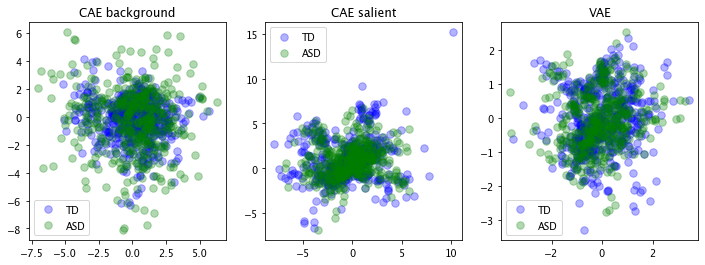

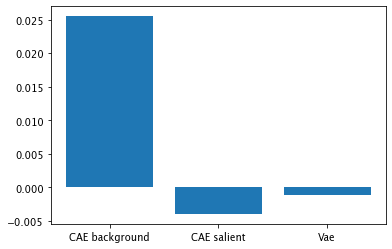

In [13]:
data = ABIDE_data
dxArr = dxArr
lbls = ['TD','ASD']

project_data(data,dxArr,lbls)

In [14]:
VAE_pred_A = vae.predict(ABIDE_data)
nsubs_a = ABIDE_data.shape[0]

In [15]:
X = np.array([ABIDE_data[s,:,:,:].flatten() for s in range(nsubs_a)])
Y = np.array([VAE_pred_A[s,:,:,:,0].flatten() for s in range(nsubs_a)])

In [16]:
def plot_acc(X,Y,dxArr,labels = None):
    mse = np.array(X-Y);mse = mse**2;mse = mse.mean(axis=1)
    vs = np.unique(dxArr)
    xs = np.arange(len(vs))

    y = [mse[dxArr==v].mean() for v in vs]
    se = [mse[dxArr==v].std() for v in vs]

    plt.bar(xs,y);
    plt.errorbar(xs,y,se,fmt='r.');
    if labels:
        plt.xticks(xs,labels=labels);
    else:
        plt.xticks(xs);
    plt.show()

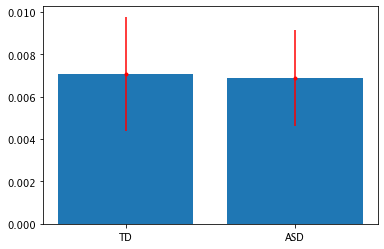

In [17]:
plot_acc(X,Y,dxArr,labels=['TD','ASD'])

In [18]:
CAE_pred = cvae.predict([ABIDE_data,ABIDE_data])

In [19]:
Y1 = np.array([CAE_pred[0][s,:,:,:,0].flatten() for s in range(nsubs_a)])
Y2 = np.array([CAE_pred[1][s,:,:,:,0].flatten() for s in range(nsubs_a)])

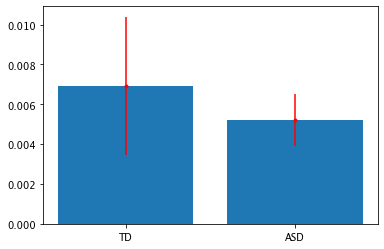

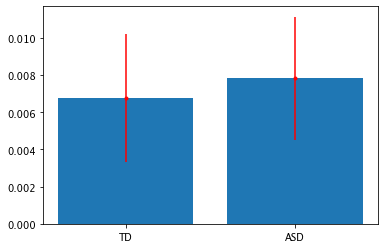

In [20]:
plot_acc(X,Y1,dxArr,labels=['TD','ASD'])
plot_acc(X,Y2,dxArr,labels=['TD','ASD'])

## SFARI

In [21]:
arr = np.load('./Data/SFARI-Anat-64iso.npz')
SFARI_data = arr['data']
SFARI_subs = arr['subs']
snsubs = SFARI_data.shape[0]
print(arr.files)
SFARI_data.shape

['data', 'subs']


(131, 64, 64, 64)

In [22]:
#dfs = pd.read_csv('./CSVs/SFARI-legend.csv')
dfs = pd.read_csv('./CSVs/DS-use.csv')
dfs = dfs.iloc[np.array([l in SFARI_subs for l in dfs['BIDS ID'].values])]

In [23]:
assert all([dfs['BIDS ID'].values[i]==SFARI_subs[i] for i in range(snsubs)]),'badness'
assert len(dfs)==len(SFARI_subs),'bad coder, bad!'

In [24]:
# SLICE: Only Keep 16p and TD
ugene = ['non-familial-control','16p-duplication','16p-deletion']
slice_arr = np.array([val in ugene for val in dfs['family_type'].values])

dfs = dfs.iloc[slice_arr]
snsubs = len(dfs)
SFARI_data = SFARI_data[slice_arr,:,:,:]
SFARI_subs = SFARI_subs[slice_arr]
print(snsubs)

121


In [25]:
dfs.head()

,BIDS ID,SVIP ID,FCAP1,SCAP1,SCAP2,family_type,genetic_status_16p,svip_diagnosis_m1,ados_css,ados_module,...,relationship_to_iip,rrb_css,sa_css,sex,svip_neuro_exam.background.head_circum,svip_neuro_exam.background.head_circum_perc,svip_neuro_exam.background.head_circum_z_score,svip_neuro_exam.measure.eval_age_months,svip_neuro_exam.measure.measure_type,age_years
0,sub-004,14705.x14,14705.x14_50_FCAP1,14705.x14_40_SCAP1,[],16p-duplication,duplication,no-diagnosis,2,ados-4,...,Mother,1,2,female,[],[],[],405,svip-neuro-exam,34
1,sub-008,14708.x10,14708.x10_60_FCAP1,14708.x10_40_SCAP1,[],16p-deletion,deletion,non-spectrum-dx,2,ados-3,...,Initially identified proband,1,3,female,54.8,[],2.08,113,svip-neuro-exam,9
2,sub-012,14713.x7,14713.x7_50_FCAP1,14713.x7_30_SCAP1,[],16p-deletion,deletion,non-spectrum-dx,6,ados-3,...,Initially identified proband,5,7,male,55.2,[],2.28,87,svip-neuro-exam,7
3,sub-014,14714.x18,14714.x18_60_FCAP1,14714.x18_40_SCAP1,[],16p-deletion,deletion,no-diagnosis,2,ados-4,...,Initially identified proband,6,2,male,55.8,[],0.49,249,svip-neuro-exam,21
4,sub-018,14718.x5,14718.x5_50_FCAP1,14718.x5_20_SCAP1,[],16p-deletion,deletion,non-spectrum-dx,1,ados-3,...,Initially identified proband,1,1,female,54,[],1.15,127,svip-neuro-exam,11


In [26]:
geneVec = np.repeat(0,snsubs)
geneVec[dfs['family_type'].values==ugene[0]]=1
geneVec[dfs['family_type'].values==ugene[1]]=2
geneVec[dfs['family_type'].values==ugene[2]]=3

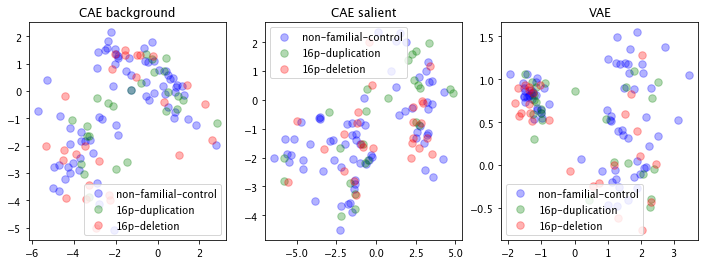

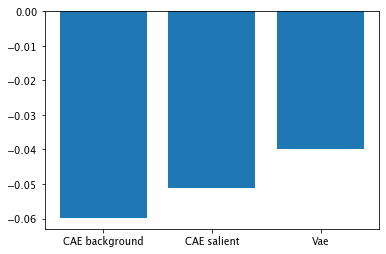

In [27]:
data = SFARI_data
dxArr = geneVec
lbls = ugene

project_data(data,dxArr,lbls)

In [28]:
SFARI_CAE_pred = cvae.predict([SFARI_data[:,:,:,:],SFARI_data[:,:,:,:]])

In [29]:
nsubs_s = SFARI_data.shape[0]

In [30]:
X = np.array([SFARI_data[s,:,:,:].flatten() for s in range(nsubs_s)])
Y1 = np.array([SFARI_CAE_pred[0][s,:,:,:,0].flatten() for s in range(nsubs_s)])
Y2 = np.array([SFARI_CAE_pred[1][s,:,:,:,0].flatten() for s in range(nsubs_s)])
[i.shape for i in [X,Y1,Y2]]

[(121, 262144), (121, 262144), (121, 262144)]

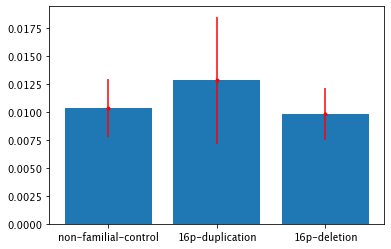

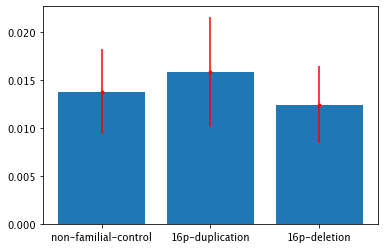

In [31]:
plot_acc(X,Y1,geneVec,ugene)
plot_acc(X,Y2,geneVec,ugene)

In [32]:
def plot_pair(X,Y,i=0,j=0):
    SFARI_data = X
    pred = Y
    plt.subplot(1,2,1)
    plt.imshow(SFARI_data[i-1,32,:,:])
    plt.xticks([]);plt.yticks([]);
    plt.title('True');

    plt.subplot(1,2,2)
    plt.imshow(pred[j][i-1,32,:,:,0])
    plt.xticks([]);plt.yticks([]);
    plt.title('True');
    plt.show()

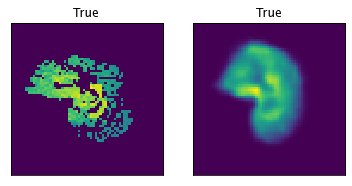

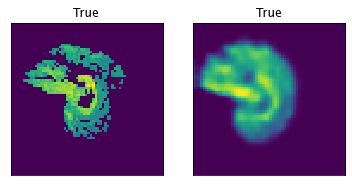

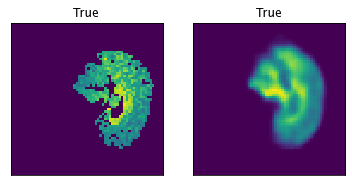

In [33]:
for i in range(3):
    plot_pair(SFARI_data[0:16,:,:,:],SFARI_CAE_pred,i,j=1)

In [34]:
#cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder

In [35]:
from sklearn.mixture import BayesianGaussianMixture
SFARI_z_projection = z_encoder(SFARI_data)
SFARI_s_projection = s_encoder(SFARI_data)
SFARI_z = np.array(SFARI_z_projection[2])
SFARI_s = np.array(SFARI_s_projection[2])
SFARI_v = np.array(encoder(np.array(SFARI_data))[2])

True
[1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0
 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0
 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1 0
 0 0 0 1 1 0 0 1 1 1]


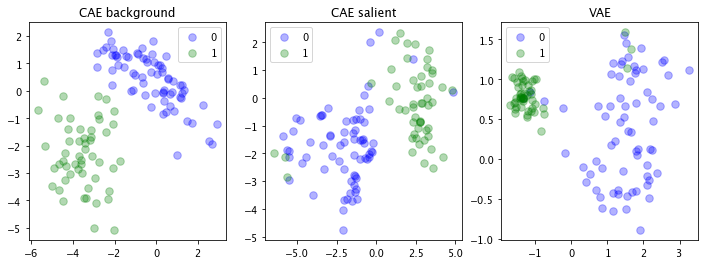

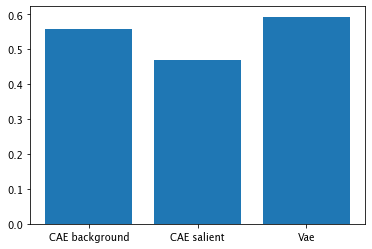

In [37]:
bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=100,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid_z = bnpc.fit_predict(np.array(SFARI_z))
print(bnpc.converged_)
print(cid_z)
project_data(SFARI_data,cid_z,[str(i) for i in np.unique(cid_z)])

True
[0 2 0 1 0 1 0 2 2 2 1 0 1 0 0 0 1 1 1 2 2 1 2 1 0 0 1 0 0 0 0 2 2 0 1 1 2
 2 0 0 0 1 0 1 1 0 2 0 1 1 1 2 1 1 0 0 1 1 2 0 0 1 1 1 1 0 0 0 1 2 1 0 0 1
 0 1 0 1 1 2 1 0 0 0 1 2 0 1 1 0 2 0 0 2 0 0 0 1 2 2 2 0 0 1 0 1 1 0 0 0 1
 2 2 2 0 0 2 1 2 0 0]


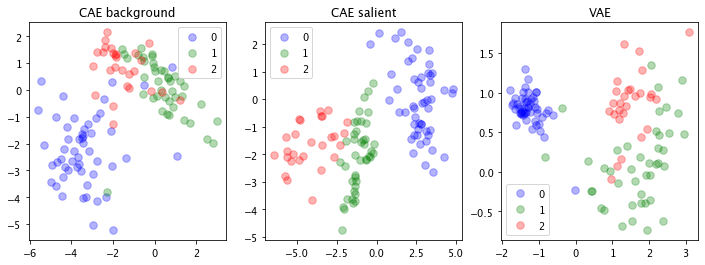

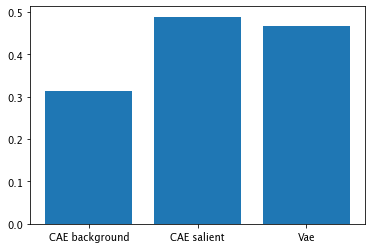

In [38]:
bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=100,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid_s = bnpc.fit_predict(np.array(SFARI_s))
print(bnpc.converged_)
print(cid_s)
project_data(SFARI_data,cid_s,[str(i) for i in np.unique(cid_s)])

True
[1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0
 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0
 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0
 0 0 0 1 1 0 0 0 1 1]


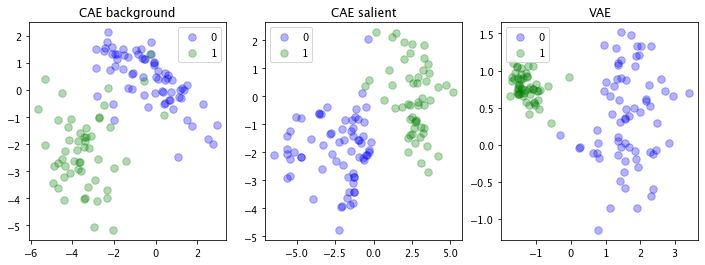

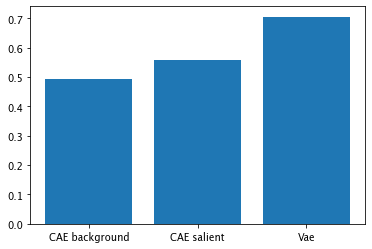

In [39]:
bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=100,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid_v = bnpc.fit_predict(np.array(SFARI_v))
print(bnpc.converged_)
print(cid_v)
project_data(SFARI_data,cid_v,[str(i) for i in np.unique(cid_v)])

<BarContainer object of 3 artists>

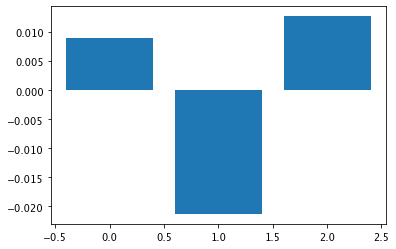

In [40]:
from sklearn.metrics import adjusted_rand_score
plt.bar([0,1,2],[adjusted_rand_score(geneVec,cid) for cid in (cid_z,cid_s,cid_v)])

In [41]:
SFARI_dxArr = np.array(dfs['clinical_asd_dx'].values=='1')*1

<BarContainer object of 3 artists>

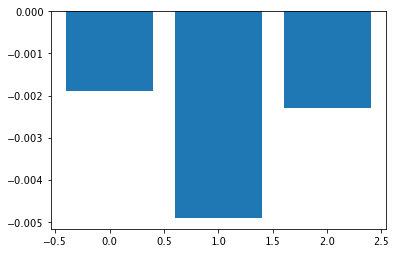

In [42]:
from sklearn.metrics import adjusted_rand_score
plt.bar([0,1,2],[adjusted_rand_score(SFARI_dxArr,cid) for cid in (cid_z,cid_s,cid_v)])

In [43]:
from sklearn.mixture import BayesianGaussianMixture
ABIDE_z_projection = z_encoder(ABIDE_data)
ABIDE_s_projection = s_encoder(ABIDE_data)
ABIDE_z = np.array(ABIDE_z_projection[2])
ABIDE_s = np.array(ABIDE_s_projection[2])
ABIDE_v = np.array(encoder(np.array(ABIDE_data))[2])

True


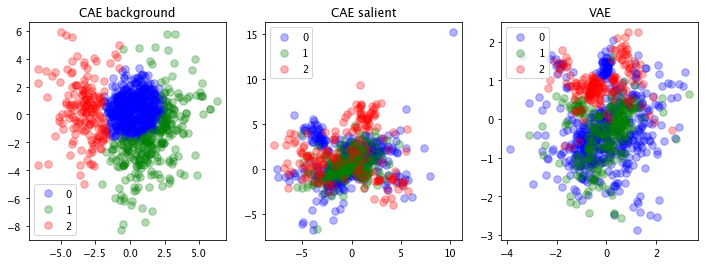

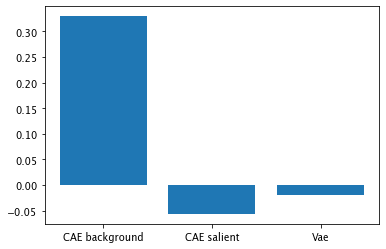

In [44]:
bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=100,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
a_cid_z = bnpc.fit_predict(np.array(ABIDE_z))
print(bnpc.converged_)
project_data(ABIDE_data,a_cid_z,[str(i) for i in np.unique(a_cid_z)])

In [45]:
print(bnpc.converged_)
project_data(ABIDE_data,np.ones(a_cid_s.shape),[str(i) for i in np.unique(np.ones(a_cid_s.shape))])

True


NameError: name 'a_cid_s' is not defined

In [ ]:
bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=100,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
a_cid_s = bnpc.fit_predict(np.array(ABIDE_s))
print(bnpc.converged_)
project_data(ABIDE_data,a_cid_s,[str(i) for i in np.unique(a_cid_s)])

In [ ]:
bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=1000, mean_precision_prior=None,mean_prior=None,n_components=50,n_init=10,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
a_cid_v = bnpc.fit_predict(np.array(ABIDE_v));
print(bnpc.converged_);
project_data(ABIDE_data,a_cid_v,[str(i) for i in np.unique(a_cid_v)])

In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(np.array(ABIDE_s))
cid_h = clusterer.labels_
project_data(ABIDE_data,cid_h,[str(i) for i in np.unique(cid_h)])

In [ ]:
from sklearn.metrics import adjusted_rand_score
plt.bar([0,1,2],[adjusted_rand_score(dxArr,cid) for cid in (a_cid_z,a_cid_s,a_cid_v)])

In [ ]:
#cvae.summary()

In [ ]:
z_encoder.summary()

In [ ]:
cvae.summary()